In [1]:
# Libraries
import numpy as np
from numpy import pi
from scipy.constants import epsilon_0, mu_0
from scipy.special import jv, jvp, hankel2, h2vp
from matplotlib import pyplot as plt
from scipy.sparse import dia_matrix
from scipy.linalg import norm
from numpy import random as rnd

# Trying different base functions in Evolutionary Algorithms

As fas as I searched, I have only found implementation of Evolutionary Algorithms (EAs) to Electromagnetic Inverse Scattering (EIS) problems using the traditional discretization by pulse functions. This implementation was first proposed by Richmond (1965) and it is a simple, light and fast way to discretize the integral equation. A possible drawback of this implementation in EAs may be lack of exchange information among neighbor pixels, which allows to assign very different contrast values for neighbor elements at the same time.

In the context of Weighted Residuals Method, the Spectral Methods is the use of global trial and test functions, i.e., functions which are defined in the whole domain. In these cases, a change in the value of a single element will result in changing neighbor pixels. This kind of implementation may be very important for recovering the electric field distribution, we expect a continuous field, while the contrast profile may not be interpreted as continuous function.

In this simple study, we will have a first look at a different discretization of the EIS problem.

## Discretization Framework

The integral equation that we are trying to solve is:

$$ E_z^s (\theta, \phi) = -\frac{jk_b^2}{4} \int_{-L_x/2}^{L_x/2} \int_{-L_y/2}^{L_y/2} H_0^{(2)}(k_b r(\theta, x, y)) \chi(x, y)E_z(\phi, x, y) dxdy $$

where $\theta$ and $\phi$ are the measurement and incidence angles, $\chi(x, y)$ and $E_z(\phi, x, y)$ are the unknown functions that we need to estimated. The framework of the Weighted Residuals Method defines the unknown functions in terms of a sum of orthogonal base (trial) functions:

$$ \chi(x, y) \approx \sum_{i = 1}^I \sum_{j = 1}^J \alpha_{ij} f^{(x)}_i(x) f^{(y)}_j(y) \\
E_z(x, y, \phi) \approx \sum_{p = 1}^P \sum_{q = 1}^Q \sum_{s=1}^{S} \beta_{pqs} g^{(x)}_p(x) g^{(y)}_q(y) g^{(\phi)}_s(\phi) $$

The Weighted Residuals Method is based on the solution of the following system of equations:

$$ (R, w_m^{(\theta)}w_n^{(\phi)}) = 0,~ m = 1, \cdots, M,~ n = 1,\cdots, N $$

which can be rewritten as:

$$\int_0^{2\pi}\int_0^{2\pi} E_z^s (\theta, \phi)w_m^{(\theta)}(\theta)w_n^{(\phi)}(\phi) d\theta d\phi = \sum_{i = 1}^I \sum_{j = 1}^J \sum_{p = 1}^P \sum_{q = 1}^Q \sum_{s=1}^{S} \alpha_{ij} \beta_{pqs} \int_0^{2\pi} w^{(\phi)}_n(\phi) g^{(\phi)}_s(\phi) d\phi \cdot \int_0^{2\pi} w^{(\theta)}_m(\theta) \left[ \int_{-L_x/2}^{L_x/2} f^{(x)}_i(x) g^{(x)}_p(x) \left\{ \int_{-L_y/2}^{L_y/2} G(\theta, x, y) f^{(y)}_j(y) g^{(y)}_q(y) dy \right\} dx \right] d\theta$$

where $w_m^{(\theta)}$ and $w_n^{(\phi)}$ are the weight functions and $G(\theta, x, y) = -\frac{jk_b^2}{4} H_0^{(2)} (k_b r(\theta, x, y))$. So, the goal is to find the $\alpha$'s and $\beta$'s values which satisfy the set of $MN$ equations.

In this study, we will assume a very simple case: let's assume only one incidence and $w_m^{(\theta)} (\theta) = \delta (\theta - \theta_m)$. Then the system of equations is reduced to:

$$E_z^s (\theta_m) = \sum_{i = 1}^I \sum_{j = 1}^J \sum_{p = 1}^P \sum_{q = 1}^Q \alpha_{ij} \beta_{pq} \int_{-L_x/2}^{L_x/2} f^{(x)}_i(x) g^{(x)}_p(x) \left[ \int_{-L_y/2}^{L_y/2} G(\theta_m, x, y) f^{(y)}_j(y) g^{(y)}_q(y) dy \right] dx, ~ m = 1,\cdots, M $$

In order to improve readability, let we denote:

$$ \Omega_{m, ijpq} =  \int_{-L_x/2}^{L_x/2} f^{(x)}_i(x) g^{(x)}_p(x) \left[ \int_{-L_y/2}^{L_y/2} G(\theta_m, x, y) f^{(y)}_j(y) g^{(y)}_q(y) dy \right] dx $$

Then, we may write the objective function of our optimization problem as:

$$ \min_{\alpha, \beta} \left\| E_{z, m}^s - \sum_{i = 1}^I \sum_{j = 1}^J \sum_{p = 1}^P \sum_{q = 1}^Q \alpha_{ij} \beta_{pq} \Omega_{m, ijpq} \right\| $$

In [2]:
def feval(alpha, beta, Omega, Ezs):
    aux = alpha.reshape((-1, 1)) @ beta.reshape((1, -1))
    fx = norm(Ezs - Omega @ aux.reshape((-1, 1)))
    return fx

## EIS problem

In this study, we will address the scattered field of a circular cylinder upon a plane incidence. This is a problem with analytic solution, i.e., there are analytic expressions for the scattered and total fields and the contrast profile. We will compute the scattered field in $M$ equally-spaced points in a circle far from the center of the cylinder by $R_O$. For this problem, we will consider the following parameters of EIS problem:

* Relative permittivity of the cylinder ($\epsilon_{rd}$): $2.0$;
* Wavelength ($\lambda$): $1.0$ \[m\];
* Radius of the circular cylinder ($a$): $\lambda/4$;
* Size of the image domain ($L_x \times L_y$): $2\lambda\times2\lambda$;
* Radius of observation ($R_O$): $2\lambda$;
* Number of measurements ($M$): 20.

In [3]:
# EIS problem - Parameters
epsilon_rd = 2.
lambdab = 1.
a = .25*lambdab
resolution = (100, 100)
Lx, Ly = 2*lambdab, 2*lambdab
Ro = 2*lambdab
M = 20

# EIS problem - Constants
E0 = 1.
kb = 2*pi/lambdab
f = 1/np.sqrt(epsilon_0*mu_0)/lambdab
omega = 2*pi*f
kd = omega*np.sqrt(epsilon_rd*epsilon_0*mu_0)
lamdad = 2*pi/kd
epsilon_d = epsilon_rd*epsilon_0

# Sum coefficients
NT = 100
n = np.arange(-NT, NT+1, dtype=float)
an = (-jv(n, kb*a)/hankel2(n, kb*a)
      * (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a))
         - jvp(n, kb*a)/(kb*a*jv(n, kb*a)))
      / (epsilon_d*jvp(n, kd*a)/(epsilon_0*kd*a*jv(n, kd*a))
         - h2vp(n, kb*a)/(kb*a*hankel2(n, kb*a))))

# Angles of measurement
phi = np.linspace(0, 2*pi, M, endpoint=False)

# Compute the scattered field
Esz = np.zeros(phi.size, dtype=complex)
for i in range(M):
    Esz[i] = E0*np.sum(1j**(-n)*an*hankel2(n, kb*Ro)*np.exp(1j*n*phi[i]))

# Cartesian coordinates of the measurement points
xm, ym = Ro*np.cos(phi), Ro*np.sin(phi)

## Configuration of trial functions

In this study, we will use periodic functions as our trial functions:

* $f^{x}_i(x) = \cos(i\pi x/L_x),~ i = 1, \cdots, I$
* $f^{y}_j(y) = \cos(j\pi y/L_y),~ j = 1, \cdots, J$
* $g^{x}_p(x) = e^{-j(p\pi/L_x)x},~ p = 1, \cdots, P$
* $g^{y}_q(x) = e^{-j(q\pi/L_y)y},~ q = 1, \cdots, Q$

The number of elements of each function will be 10.

In [4]:
# Number of elements
I, J, P, Q = 10, 10, 10, 10

# Set mesh
NX, NY = 100, 100
x, y = np.meshgrid(np.linspace(-Lx/2, Lx/2, NX),
                   np.linspace(-Ly/2, Ly/2, NY))
dx, dy = x[0, 1]-x[0, 0], y[1, 0]-y[0, 0]

# f^{(x)}_i (x)
fi = np.zeros((I, NY, NX), dtype=complex)
for i in range(I):
    fi[i, :, :] = np.cos((i+1)*pi/Lx*x)

# f^{(y)}_j (y)
fj = np.zeros((J, NY, NX), dtype=complex)
for j in range(J):
    fj[j, :, :] = np.cos((j+1)*pi/Ly*y)

# g^{(x)}_p (x)
gp = np.zeros((P, NY, NX), dtype=complex)
for p in range(P):
    gp[p, :, :] = np.exp(-1j*((p+1)*pi/Lx)*x)

# g^{(y)}_q (y)
gq = np.zeros((Q, NY, NX), dtype=complex)
for q in range(Q):
    gq[q, :, :] = np.exp(-1j*((q+1)*pi/Ly)*y)

# Compute the integrals
Omega = np.zeros((M, I*J*P*Q), dtype=complex)
G = np.zeros((M, NX*NY), dtype=complex)
for m in range(M):
    r = np.sqrt((xm[m]-x.flatten())**2 + (ym[m]-y.flatten())**2)
    G[m, :] = (-1j*kb**2/4)*hankel2(0, kb*r)
    n = 0
    for i in range(I):
        for j in range(J):
            for p in range(P):
                for q in range(Q):
                    Omega[m, n] = np.trapz(np.trapz(G[m, :].reshape((NY, NX))
                                                    * fi[i, :, :]
                                                    * fj[j, :, :]
                                                    * gp[p, :, :]
                                                    * gq[q, :, :],
                                                    x=x[0, :]),
                                           x=y[:, 0])
                    n += 1

## The Particle Swarm Optimization

The EA implemented in this study will be the Particle Swarm Optimization (PSO) algorithm. For this implementation, we will use:

* Number of particles ($N_{PAR}$): 250
* Number of iterations ($N_{ITER}$): 20,000
* Inertia weight ($w$): 0.4
* Acceleration coefficients ($c_1$, $c_2$): 2.0

In [15]:
NVARX = I*J  # Number of variables
NVARE = P*Q
NPAR = 250  # Number of particles

PX = np.zeros((NPAR, NVARX))  # array of contrast particles
PE = np.zeros((NPAR, NVARE), dtype=complex)  # array of electric field particles
vx = np.zeros((NPAR, NVARX))  # array of contrast velocities
ve = np.zeros((NPAR, NVARE), dtype=complex)  # array of contrast velocities
fx = np.zeros(NPAR)  # evaluation of each particle

pxbest = np.zeros((NPAR, NVARX))
pebest = np.zeros((NPAR, NVARE), dtype=complex)
fx_pbest = np.inf*np.ones(fx.shape)  # Initial evaluation of pbest particles

gxbest = np.zeros(NVARX)
gebest = np.zeros(NVARE, dtype=complex)
fx_gbest = np.inf  # Initial evaluation of gbest particle

c1 = c2 = 2.  # Parameters for velocity update
w = .4

NITER = 20000  # Number of iterations
convergence = np.zeros(NITER)

## Optimization process

The particles will be initialized as follows:

* The contrast variables ($\alpha$) will be initialized as real random numbers with uniform distribution between 0 and 1;
* The electric field variables ($\beta$) will be initialized as complex random numbers with standard normal distribution.

Then the PSO algorithm will be executed in the traditional way:

Iteration 0 - Best f(x): 3.597e+02
Iteration 2000 - Best f(x): 1.113e+01
Iteration 4000 - Best f(x): 8.897e+00
Iteration 6000 - Best f(x): 7.614e+00
Iteration 8000 - Best f(x): 6.804e+00
Iteration 10000 - Best f(x): 6.326e+00
Iteration 12000 - Best f(x): 6.094e+00
Iteration 14000 - Best f(x): 5.863e+00
Iteration 16000 - Best f(x): 5.773e+00
Iteration 18000 - Best f(x): 5.564e+00


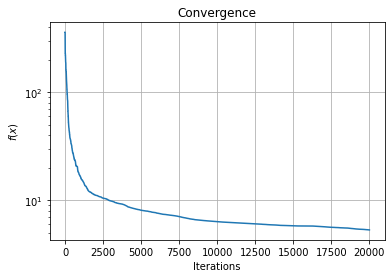

In [16]:
PX[:, :] = rnd.rand(NPAR, NVARX)  # Initialize particles
PE[:, :] = rnd.normal(size=(NPAR, NVARE)) + 1j*rnd.normal(size=(NPAR, NVARE))
for i in range(NPAR):
    fx[i] = feval(PX[i, :], PE[i, :], Omega, Esz)  # Evaluate particles

for it in range(NITER):

    # Update pbest
    for n in range(NPAR):
        if fx[n] < fx_pbest[n]:
            pxbest[n, :] = PX[n, :]
            pebest[n, :] = PE[n, :]
            fx_pbest[n] = fx[n]

    # Update gbest
    if np.amin(fx_pbest) < fx_gbest:
        n = np.argsort(fx_pbest)[0]
        gxbest[:] = pxbest[n, :]
        gebest[:] = pebest[n, :]
        fx_gbest = fx_pbest[n]

    # Calculate particle velocity
    vx = w*vx + c1*rnd.rand(NPAR, NVARX)*(pxbest-PX) + c2*rnd.rand(NPAR, NVARX)*(np.tile(gxbest, (NPAR, 1))-PX)
    ve = w*ve + c1*rnd.rand(NPAR, NVARE)*(pebest-PE) + c2*rnd.rand(NPAR, NVARE)*(np.tile(gebest, (NPAR, 1))-PE)

    # Update particle position
    PX = PX + vx
    PE = PE + ve

    # Update particle evalution
    for i in range(NPAR):
        fx[i] = feval(PX[i, :], PE[i, :], Omega, Esz)  # Evaluate particles

    # Record convergence
    convergence[it] = fx_gbest

    if NITER == 10:
        print('Iteration %d' % it + ' - Best f(x): %.3e' % fx_gbest)
    elif it % (NITER/10) == 0:
        print('Iteration %d' % it + ' - Best f(x): %.3e' % fx_gbest)

# Plot convergence curve
plt.semilogy(range(NITER), convergence, '-')
plt.grid()
plt.xlabel('Iterations')
plt.ylabel(r'$f(x)$')
plt.title('Convergence')

plt.show()

## Results

The final global best solution was:

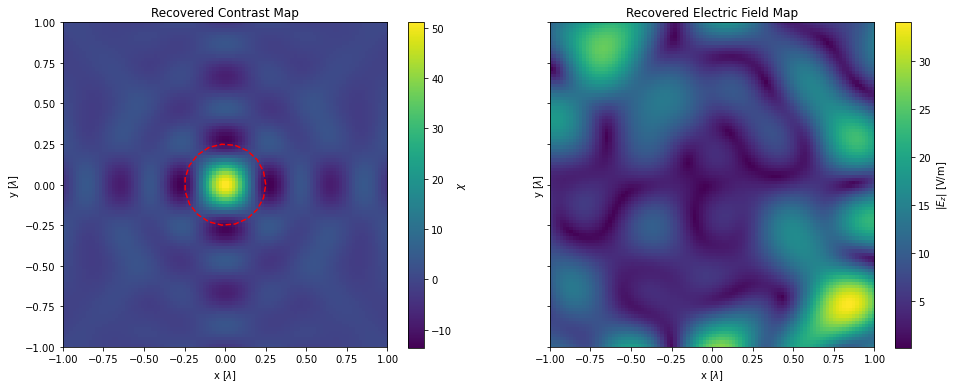

In [17]:
# Image mesh
dy, dx = Ly/resolution[0], Lx/resolution[1]
x, y = np.meshgrid(np.arange(-Lx/2 + dx/2, Lx/2, dx),
                   np.arange(-Ly/2 + dy/2, Ly/2, dy))

# Compute the contrast function
chi = np.zeros(x.shape)
gxbest = gxbest.reshape((I, J))
for i in range(1, I+1):
    for j in range(1, J+1):
        chi = chi + gxbest[i-1, j-1]*np.cos(i*pi/Lx*x)*np.cos(j*pi/Ly*y)
        n += 1

# Compute the electric field function
Ez = np.zeros(x.shape, dtype=complex)
gebest = gebest.reshape((I, J))
for p in range(1, P+1):
    for q in range(1, Q+1):
        Ez = Ez + gebest[p-1, q-1]*np.exp(-1j*p*pi/Lx*x)*np.exp(-1j*q*pi/Ly*y)
        n += 1

# Set image object
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=True)

# Plot recovered contrast map
img = axis[0].imshow(chi, extent=[-Lx/2/lambdab, Lx/2/lambdab, -Ly/2/lambdab, Ly/2/lambdab])
cbar1 = fig.colorbar(img, ax=axis[0])
cbar1.set_label(r'$\chi$')
axis[0].set_xlabel(r'x [$\lambda$]')
axis[0].set_ylabel(r'y [$\lambda$]')
axis[0].set_title('Recovered Contrast Map')

# Plot the bounds of the orginal profile
axis[0].plot(a/lambdab*np.cos(np.linspace(0, 2*pi, 20)),
             a/lambdab*np.sin(np.linspace(0, 2*pi, 20)),
             'r--')

# Plot the recovered electric field map
img = axis[1].imshow(np.abs(Ez), extent=[-Lx/2/lambdab, Lx/2/lambdab, -Ly/2/lambdab, Ly/2/lambdab])
cbar1 = fig.colorbar(img, ax=axis[1])
cbar1.set_label(r'$|E_z|$ [V/m]')
axis[1].set_xlabel(r'x [$\lambda$]')
axis[1].set_ylabel(r'y [$\lambda$]')
axis[1].set_title('Recovered Electric Field Map')

plt.show()

The algorithm was able to recover a scatter at the center of the figure. However, the scale of the contrast map is much wider than the original profile. The recovered electric field map is also very different the correct one.

## Conclusions

A first thing which we want to highlight is that the bottleneck of this implementation is the evaluation of the integrals, which may take too long. This may be improved by using the Numba Package or maybe an implementation in Cuda.

Although the algorithm is stochastic and different executions may givee different results, I'm a bit suprised that, in almost 5 times that this script was run, the results looked almost the same. I do not know if this formulation makes the problem to be a convex one, but this is definitely curious.

Some ways to improve the contrast estimation must be thought. We may try: (i) to add a regularization term such as Tikhonov Regularization; (ii) to add the state equation to the objective function (which may be a little bit complicated because of the singularity in the Green function).